In [29]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

derivative of loss $L$ with respect to the model's output $\hat{y}$
$$L_{i} = (y_{i} - \hat{y}_{i})^2$$
Using the chain rule, the derivative with respect to $\hat{y}_{i}$ is:
$$\frac{\partial{L_{i}}}{\partial{\hat{y}_{i}}} = 2(y_{i} - \hat{y}_{i}) . (-1) = -2(y_{i} - \hat{y}_{i})$$

<b>'w.grad = X.T @ grad_pred'</b> it calculates the derivative of the loss L with respect to the weight w.
Chain rule: $\frac{\partial{L}}{\partial{w}}$:
$$ \frac{\partial{L}}{\partial{w}} = \frac{\partial{L}}{\partial{\hat{y}}} . \frac{\partial{\hat{y}_{i}}}{\partial{w}} $$

We already have the first part, which is grad_pred.
The second part is the derivative of the model's prediction $ (\hat{y} = Xw + b) $ with respect to w. This derivative, $ \frac{\partial{L}}{\partial{w}} $ , is simply X.

To combine these correctly, we can't just multiply X and grad_pred due to their matrix shapes. The correct vectorized operation is to multiply the transpose of X by grad_pred.

If X is ($ n_{samples} $, $ n_{features} $) and grad_pred is ($ n_{samples} $, 1), then $ X^T $ is ($ n_{features} $, $ n_{samples} $).

$ X^T $ @ grad_pred results in a shape of ($ n_{features} $, 1), which is exactly the shape we need for the gradient of our weight w

In [30]:
X = 2 * np.random.rand(100, 1)
y = 1 + 2 * X + np.random.randn(100, 1)

class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros_like(data)

def linear_model(X, w, b):
    return X @ w.data + b.data

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def compute_gradients(X, y_true, y_pred, w, b):
    n_samples = len(y_true)
    grad_pred = -2 * (y_true - y_pred) / n_samples

    w.grad = X.T @ grad_pred
    b.grad = np.sum(grad_pred)

## Stochastic Gradient Descent (SGD)

the update rule is : 
$$ w_{t} = w_{t} - \eta \nabla L(w_{t})$$

where:
* $w_{t}$ is the parameter (weight or bias) at step $t$.
* $\eta$ is the learning rate.
* $\nabla L(w_{t})$ is the gradient of the loss function calculated on a single data point.


In [31]:
class SGD:
    def __init__(self, params, lr=0.01):
        '''params (list): A list of Parameter objects to optimize
           lr (float): The learning rate.'''
        self.params = params
        self.lr = lr
    def step(self):
        for p in self.params:
            p.data -= self.lr * p.grad
    def zero_grad(self):
        #Resets the gradients of all parameters to zero
        for p in self.params:
            p.grad = np.zeros_like(p.data)

## SGD with Momentum
It introduces a "velocity" term that accumulates an exponentially decaying moving average of past gradients. This helps the optimizer build momentum in a consistent direction and dampens oscillations.

update rules:
* Updata Velocity: $ v_{t} + 1 = \beta v_{t} + \eta \nabla L(w_{t}) $

  $ v_{t} + 1 = \beta v_{t} + (1 - \beta) \eta \nabla L(w_{t}) $, this is EWMA.
  Exponentially Weighted Moving Average, its purpose is to calculate a stable average of the recent gradients.
  * The (1-$\beta$) term is a normalization factor. It ensures that the resulting average '$v$' stays on the same scale as the gradients themselves.
  * This formula is the core building block for more advanced optimizers like Adam and RMSprop. They use EWMA to keep a running average of the gradient (the "first moment") and the squared gradient (the "second moment").
* Update Parameter: $ w_{t} + 1 = w_{t} - v_{t} + 1 $
  
where:
* $v_{t}$ is the velocity at step $t$
* $\beta$(beta) is the momentum coefficient, usually set to a value like 0.9

In [32]:
class SGDMomentum:
    def __init__(self, params, lr=0.01, momentum=0.9):
        """ params (list): A list of Parameter objects to optimize
            lr (float): The learning rate
            momentum (float): The momentum coefficient (beta)"""
        self.params = params
        self.lr = lr
        self.momentum = momentum
        self.velocities = [np.zeros_like(p.data) for p in self.params]

    def step(self):
        for i, p in enumerate(self.params):
            self.velocities[i] = self.momentum * self.velocities[i] + self.lr * p.grad
            p.data -= self.velocities[i]

    def zero_grad(self):
        for p in self.params:
            p.grad = np.zeros_like(p.data)

Optimizer: SGD
Final Weights: w=1.85, b-1.26
Optimizer: SGDMomentum
Final Weights: w=1.88, b-1.25


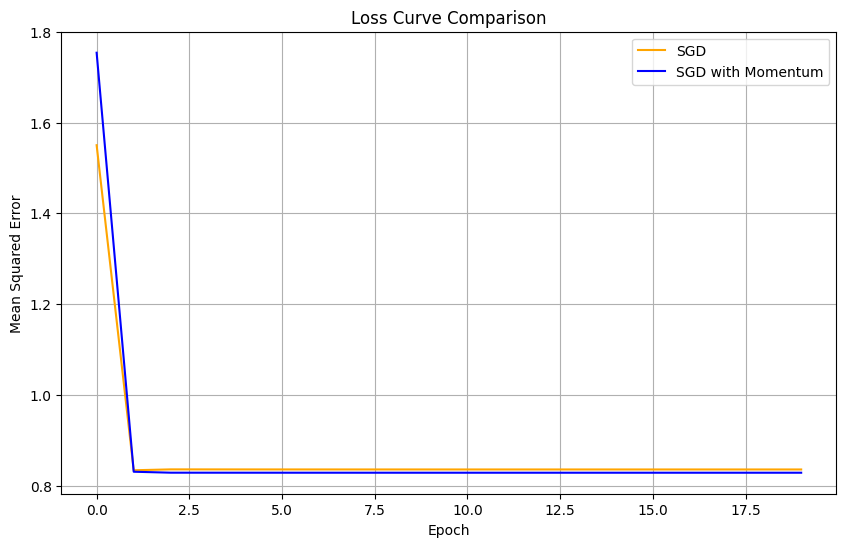

In [ ]:
def train(optimizer, epochs=100):
    """ A generic training loop """

    loss_history = []

    for epoch in range(epochs):
        epoch_loss = 0
        for i in range(len(X)):
            x_sample = X[i:i+1]
            y_sample = y[i:i+1]

            w, b = optimizer.params

            y_pred = linear_model(x_sample, w, b)

            epoch_loss += mse_loss(y_sample, y_pred)

            optimizer.zero_grad()

            compute_gradients(x_sample, y_sample, y_pred, w, b)

            optimizer.step()

        loss_history.append(epoch_loss / len(X))
    
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"Final Weights: w={w.data.item():.2f}, b-{b.data.item():.2f}")
    return loss_history

# Trianing


np.random.seed(42)
w1_sgd = Parameter(np.random.randn(1, 1))
b1_sgd = Parameter(np.zeros(1))
sgd_optimizer = SGD(params=[w1_sgd, b1_sgd], lr=0.01)

np.random.seed(42)
w2_momentum = Parameter(np.random.randn(1, 1))
b2_momentum = Parameter(np.zeros(1))
momentum_optimizer = SGDMomentum(params=[w2_momentum, b2_momentum], lr=0.001, momentum=0.9)

sgd_losses = train(sgd_optimizer, epochs=20)
momentum_losses = train(momentum_optimizer, epochs=20)

plt.figure(figsize=(10, 6))
plt.plot(sgd_losses, label='SGD', color='orange')
plt.plot(momentum_losses, label='SGD with Momentum', color='blue')
plt.title('Loss Curve Comparison')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\ipympl\backend_nbagg.py:335: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) DejaVu Sans.
  self.figure.savefig(buf, format='png', dpi='figure')


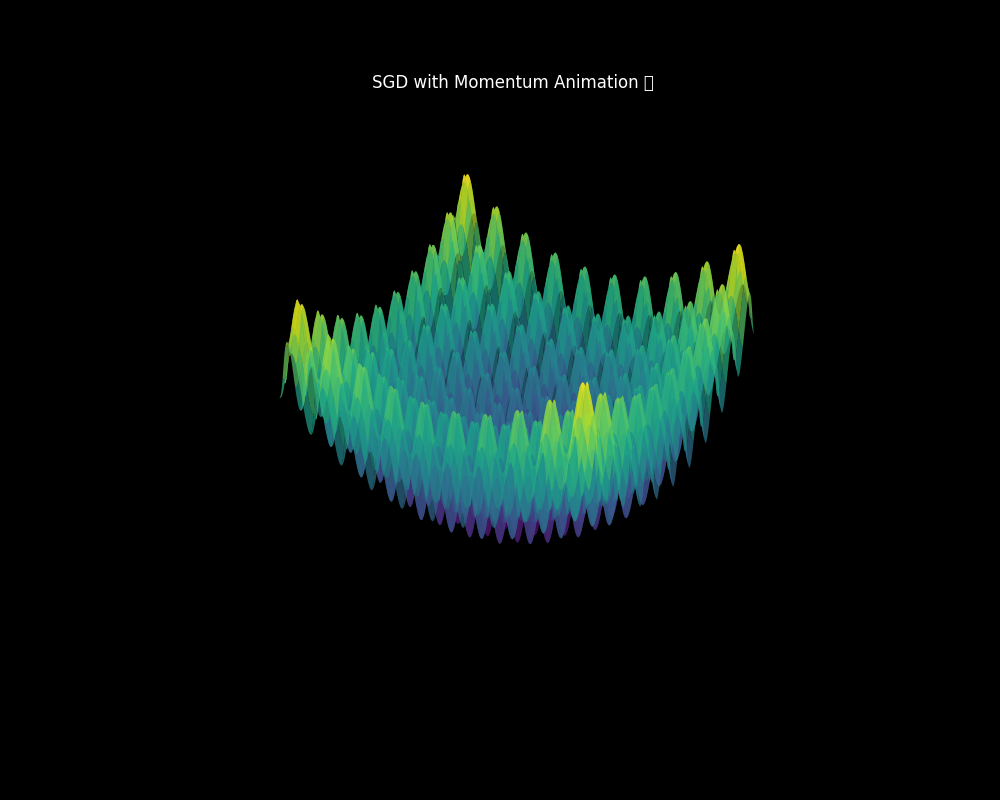

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


%matplotlib widget

def func(x, y):
    # A is amplitude, n is number of variables (2)
    A = 10
    n = 2
    return (A * n) + (x**2 - A * np.cos(2 * np.pi * x)) + (y**2 - A * np.cos(2 * np.pi * y))

def pd_x(x, y):
    return 2 * x + 20 * np.pi * np.sin(2 * np.pi * x)
def pd_y(x, y):
    return 2 * y + 20 * np.pi * np.sin(2 * np.pi * y)

x_grid = np.arange(-5, 5, 0.05)
y_grid = np.arange(-5, 5, 0.05)
X, Y = np.meshgrid(x_grid, y_grid)
Z = func(X, Y)


current_pos = (3.5, -4.0, func(3.5, -4.0))
lr = 0.001
beta = 0.9
velocity_x = 0
velocity_y = 0
path = [current_pos]


plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")
ax.axis('off')
ax.plot_surface(X, Y, Z, cmap="viridis", zorder=0, alpha=0.7)
path_plot, = ax.plot([], [], [], color='white', linewidth=2, zorder=1)
point_plot = ax.scatter([], [], [], color='red', s=80, zorder=1)
ax.set_title("SGD with Momentum Animation 💨")


def update(frame):
    global current_pos, velocity_x, velocity_y, path

    
    for _ in range(10):
        x_derivative = pd_x(current_pos[0], current_pos[1])
        y_derivative = pd_y(current_pos[0], current_pos[1])

        velocity_x = beta * velocity_x + lr * x_derivative
        velocity_y = beta * velocity_y + lr * y_derivative

        x_new = current_pos[0] - velocity_x
        y_new = current_pos[1] - velocity_y

        current_pos = (x_new, y_new, func(x_new, y_new))
        path.append(current_pos)
    
   
    path_np = np.array(path)
    path_plot.set_data(path_np[:, 0], path_np[:, 1])
    path_plot.set_3d_properties(path_np[:, 2])

    point_plot._offsets3d = ([current_pos[0]], [current_pos[1]], [current_pos[2]])
    
    return path_plot, point_plot

ani = FuncAnimation(fig, update, frames=100, blit=False, interval=50)

plt.show()
